##  Import Library & Inisialisasi NLP Tools

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Labeling Otomatis dengan Model RoBERTa Bahasa Indonesia

In [ ]:
from transformers import pipeline, AutoTokenizer
import pandas as pd
from tqdm.notebook import tqdm

df = pd.read_csv('scrapped_comments.csv')
df.dropna(inplace=True)
df = df.head(12000).copy()

model_name = "w11wo/indonesian-roberta-base-sentiment-classifier"
sentiment_pipeline = pipeline("text-classification", model=model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

label_mapping = {
    'negative': 'negatif',
    'neutral': 'netral',
    'positive': 'positif'
}

def get_label(text):
    tokens = tokenizer(text, max_length=512, truncation=True, return_tensors="pt")
    truncated_text = tokenizer.decode(tokens['input_ids'][0], skip_special_tokens=True)
    result = sentiment_pipeline(truncated_text)[0]
    return label_mapping[result['label']]

tqdm.pandas()
df['label'] = df['Comment'].progress_apply(get_label)

df = df[['Comment', 'label']]
df.to_csv('labeled_comments.csv', index=False)
print("File saved as labeled_comments.csv ✅")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/808k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/467k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0


  0%|          | 0/12000 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


File saved as labeled_comments.csv ✅


## Preprocessing Teks & Encoding Label

In [ ]:
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[^\x00-\x7F]+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text

df['cleaned'] = df['Comment'].apply(clean_text)

le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])

df = df[df['cleaned'].str.strip().astype(bool)]
df.dropna(subset=['cleaned'], inplace=True)
df = df[df['cleaned'].str.strip() != '']

df.to_csv('labeled_comments.csv', index=False)
print(f"Jumlah dataset akhir: {len(df)} sampel")


Jumlah dataset akhir: 11785 sampel


<ipython-input-3-8d79c2d4fa55>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned'] = df['Comment'].apply(clean_text)
<ipython-input-3-8d79c2d4fa55>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label_enc'] = le.fit_transform(df['label'])  # 0=negatif, 1=netral, 2=positif


## Pelatihan Model LSTM dengan Embedding FastText

In [ ]:
pip install fasttext scikit-learn pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313507 sha256=d0a28bbba89e0e5c8bc3bceb549a85262185c5bf19832eb0e3b98cf0c99441d6
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


Loading dataset...
Training FastText...
Splitting dataset...
Training model LSTM...
Epoch 1/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.5142 - loss: 0.9689 - val_accuracy: 0.6692 - val_loss: 0.7651
Epoch 2/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7286 - loss: 0.6191 - val_accuracy: 0.7201 - val_loss: 0.5306
Epoch 3/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8459 - loss: 0.3984 - val_accuracy: 0.9359 - val_loss: 0.2058
Epoch 4/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9356 - loss: 0.1999 - val_accuracy: 0.9519 - val_loss: 0.1347
Epoch 5/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9561 - loss: 0.1442 - val_accuracy: 0.9651 - val_loss: 0.1222
Epoch 6/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9662 - loss: 0.1157 - val_accuracy: 0.9595 - val_loss: 0.1184
Epoch 7/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9618 - loss: 0.1316 - val_accuracy: 0.9529 - val_loss: 0.1636
Epoch 8/10
2

Model berhasil disimpan sebagai lstm_sentiment_model.h5 ✅
Evaluating model...
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Accuracy: 0.9711620016963528
              precision    recall  f1-score   support

     negatif       0.98      0.98      0.98       521
      netral       0.94      0.99      0.96       268
     positif       0.99      0.94      0.96       390

    accuracy                           0.97      1179
   macro avg       0.97      0.97      0.97      1179
weighted avg       0.97      0.97      0.97      1179



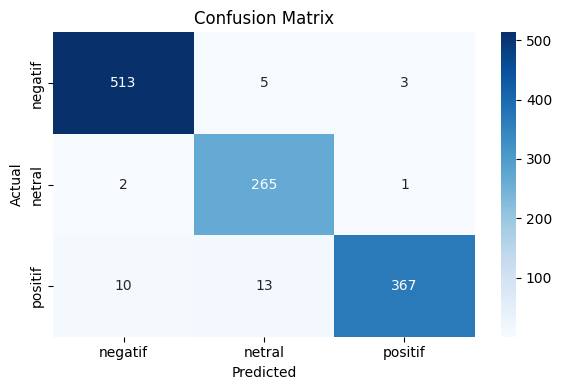

In [ ]:
import pandas as pd
import re
import fasttext
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|@\w+|[^a-z\s]", " ", text)
    text = re.sub(r"[^\x00-\x7F]+", "", text)
    text = text.replace("\n", " ")
    return text.strip()

print("Loading dataset...")
df = pd.read_csv("labeled_comments.csv")
df.dropna(inplace=True)
df["cleaned"] = df["Comment"].apply(clean_text)
df = df[df["cleaned"].str.strip().astype(bool)]

le = LabelEncoder()
df["label_enc"] = le.fit_transform(df["label"])
y = df["label_enc"]

print("Training FastText...")
df_fasttext = df[["cleaned", "label_enc"]].copy()
df_fasttext["fasttext"] = "__label__" + df_fasttext["label_enc"].astype(str) + " " + df_fasttext["cleaned"]
df_fasttext["fasttext"].to_csv("fasttext_train.txt", index=False, header=False)

ft_model = fasttext.train_supervised(input="fasttext_train.txt", epoch=10, lr=1.0, wordNgrams=2, verbose=1)

X = np.vstack([ft_model.get_sentence_vector(text) for text in df["cleaned"]])

print("Splitting dataset...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

from tensorflow.keras.utils import to_categorical
num_classes = len(np.unique(y))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print("Training model LSTM...")
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

X_train_r = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_r = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

history = model.fit(
    X_train_r, y_train_cat,
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)

model.save("lstm_model.h5")
print("Model berhasil disimpan sebagai lstm_sentiment_model.h5 ✅")

print("Evaluating model...")
y_pred_probs = model.predict(X_test_r)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


## Menyimpan Model

In [ ]:
import joblib
import pickle

model.save('lstm_model.h5')
print("Model LSTM disimpan sebagai 'lstm_model.h5'")

ft_model.save_model('fasttext_model.bin')
print("Model FastText disimpan sebagai 'fasttext_model.bin'")

joblib.dump(le, 'label_encoder.pkl')
print("LabelEncoder disimpan sebagai 'label_encoder.pkl'")

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Tokenizer disimpan sebagai 'tokenizer.pickle'")


Model LSTM disimpan sebagai 'lstm_model.h5'
Model FastText disimpan sebagai 'fasttext_model.bin'
LabelEncoder disimpan sebagai 'label_encoder.pkl'
Tokenizer disimpan sebagai 'tokenizer.pickle'
